In [1]:
from model_visit import VisitModel
from model_image import Resnet
import tensorflow as tf
import numpy as np
import pandas as pd
import sys
import os



os.environ["CUDA_VISIBLE_DEVICES"] = '7'
table = pd.read_csv("../data/valid.txt", header=None)
filenames1 = [item[0] for item in table.values]
filenames2 = [item[0].split('/')[-1].split('.')[0] for item in table.values]

graph1 = tf.Graph()
sess_visit = tf.InteractiveSession(graph=graph1)
with sess_visit.graph.as_default():
    with sess_visit.as_default():
        visit_model = VisitModel()
        sess_visit.run(tf.local_variables_initializer())
        sess_visit.run(tf.global_variables_initializer())
        var_list = [var for var in tf.global_variables() if "moving" in var.name]
        var_list += [var for var in tf.global_variables() if "global_step" in var.name]
        var_list += tf.trainable_variables()
        saver1 = tf.train.Saver(var_list=var_list, max_to_keep=1)
        saver1.restore(sess_visit, "../model/1011/model.ckpt-500")
        
graph2 = tf.Graph()
sess_image = tf.InteractiveSession(graph=graph2)
with sess_image.graph.as_default():
    with sess_image.as_default():
        image_model = Resnet()
        sess_image.run(tf.local_variables_initializer())
        sess_image.run(tf.global_variables_initializer())
        var_list = [var for var in tf.global_variables() if "moving" in var.name]
        var_list += [var for var in tf.global_variables() if "global_step" in var.name]
        var_list += tf.trainable_variables()
        saver2 = tf.train.Saver(var_list=var_list, max_to_keep=1)
        saver2.restore(sess_image, "../model/1006/model.ckpt-4000")            
            

Tensor("Resnet/stage1/Relu:0", shape=(?, 7, 26, 32), dtype=float32)
Tensor("Resnet/stage2/residual/Relu_2:0", shape=(?, 7, 26, 64), dtype=float32)
Tensor("Resnet/stage3/residual/Relu_2:0", shape=(?, 4, 13, 128), dtype=float32)
Tensor("Resnet/stage4/residual/Relu_2:0", shape=(?, 2, 7, 256), dtype=float32)
Tensor("Resnet/stage5/residual/Relu_2:0", shape=(?, 1, 4, 512), dtype=float32)
Tensor("Resnet/stage5/AvgPool:0", shape=(?, 1, 1, 512), dtype=float32)
Tensor("Resnet/fc/flatten/Reshape:0", shape=(?, 512), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

网络初始化成功
INFO:tensorflow:Restoring parameters from ../model/1011/model.ckpt-500
Tensor("Resnet/stage1/Relu:0", shape=(?, 88, 88, 16), dtype=float32)


/root/anaconda3/envs/czczcz/lib/python3.6/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Tensor("Resnet/stage2/residual/Relu_2:0", shape=(?, 44, 44, 32), dtype=float32)
Tensor("Resnet/stage3/residual/Relu_2:0", shape=(?, 22, 22, 64), dtype=float32)
Tensor("Resnet/stage4/residual/Relu_2:0", shape=(?, 11, 11, 128), dtype=float32)
Tensor("Resnet/stage5/residual/Relu_2:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("Resnet/stage5/AvgPool:0", shape=(?, 1, 1, 256), dtype=float32)
Tensor("Resnet/fc/flatten/Reshape:0", shape=(?, 256), dtype=float32)
网络初始化成功
INFO:tensorflow:Restoring parameters from ../model/1006/model.ckpt-4000


测试完成
[165, 86, 26, 14, 100, 76, 112, 89, 127]
[0.825, 0.43, 0.13, 0.07, 0.5, 0.38, 0.56, 0.445, 0.635]
0.44166666666666665


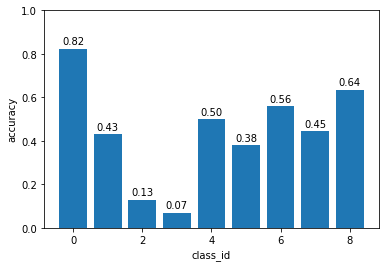

In [2]:
predictions = {}
length = len(filenames2)
data = []
labels = []
for index, filename in enumerate(filenames2):
    array = np.load("../data/train_visit/"+filename+".npy")
    class_id = int(filename.split('_')[-1])
    data.append(array)
    labels.append(class_id)

predictions = sess_visit.run(tf.argmax(visit_model.output, 1), 
                          feed_dict={visit_model.image: data, 
                                     visit_model.training: False})
softmax_visit = sess_visit.run(tf.nn.softmax(visit_model.output), 
                          feed_dict={visit_model.image: data, 
                                     visit_model.training: False})
print("测试完成")
scores = [0,0,0,0,0,0,0,0,0]
for index, prediction in enumerate(predictions):
    if(labels[index] == prediction+1):
        scores[prediction] += 1
print(scores)

avg = [score/200 for score in scores]
print(avg)
print(sum(scores)/1800)

import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(range(len(avg)), avg)
plt.xlabel('class_id')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
for x,y in zip(range(len(avg)),avg):
    plt.text(x, y+0.01, '%.2f' % y, ha='center', va= 'bottom')
plt.show()

测试完成
[20, 16, 64, 92, 150, 54, 98, 25, 54]
[0.1, 0.08, 0.32, 0.46, 0.75, 0.27, 0.49, 0.125, 0.27]
0.31833333333333336


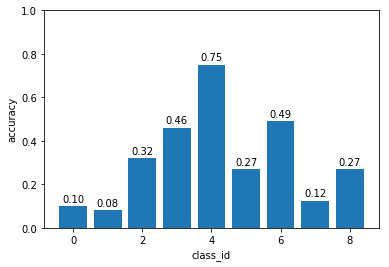

In [3]:
import cv2

predictions = {}
length = len(filenames1)
data = []
labels = []
for index, filename in enumerate(filenames1):
    image = cv2.imread(filename, cv2.IMREAD_COLOR)[0:88,0:88,:] / 255.0
    class_id = int(filename.split('_')[-1].split('.')[0])
    data.append(image)
    labels.append(class_id)

predictions = sess_image.run(tf.argmax(image_model.output, 1), 
                          feed_dict={image_model.image: data, 
                                     image_model.training: False})
softmax_image = sess_image.run(tf.nn.softmax(image_model.output), 
                          feed_dict={image_model.image: data, 
                                     image_model.training: False})
print("测试完成")
scores = [0,0,0,0,0,0,0,0,0]
for index, prediction in enumerate(predictions):
    if(labels[index] == prediction+1):
        scores[prediction] += 1
print(scores)

avg = [score/200 for score in scores]
print(avg)
print(sum(scores)/1800)

import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(range(len(avg)), avg)
plt.xlabel('class_id')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
for x,y in zip(range(len(avg)),avg):
    plt.text(x, y+0.01, '%.2f' % y, ha='center', va= 'bottom')
plt.show()

[144, 80, 43, 72, 158, 77, 132, 88, 128]
[0.72, 0.4, 0.215, 0.36, 0.79, 0.385, 0.66, 0.44, 0.64]
0.5122222222222222


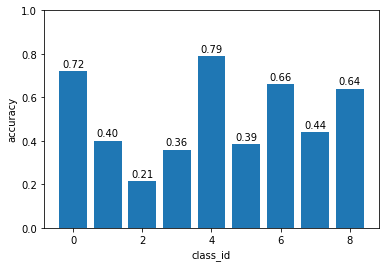

In [12]:
predictions = []


for i in range(len(softmax_image)):
    
    softmax_sum = softmax_image[i]+softmax_visit[i]
    prediction = np.argmax(softmax_sum)
    predictions.append(prediction)
    
scores = [0,0,0,0,0,0,0,0,0]
for index, prediction in enumerate(predictions):
    if(labels[index] == prediction+1):
        scores[prediction] += 1
print(scores)

avg = [score/200 for score in scores]
print(avg)
print(sum(scores)/1800)

import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(range(len(avg)), avg)
plt.xlabel('class_id')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
for x,y in zip(range(len(avg)),avg):
    plt.text(x, y+0.01, '%.2f' % y, ha='center', va= 'bottom')
plt.show()

In [7]:

List1 = [1,2,3]
List2 = [5,6,7]
List3 = np.multiply(np.array(List1),np.array(List2))
print(List3.tolist())

[5, 12, 21]
